In [1]:
!pip install kagglehub
!pip install kaggle

In [2]:
import kagglehub
import os
import zipfile
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import time
from tensorflow.keras import layers


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("veeralakrishna/cat-faces-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cat-faces-dataset


In [4]:
def load_images(data_dir):
    image_paths = glob.glob(data_dir + "/**/*.png", recursive=True)
    images = []
    for path in image_paths:
        try:
            img = Image.open(path).convert("RGB").resize((64, 64))
            img_array = (np.asarray(img, dtype=np.float32) - 127.5) / 127.5
            images.append(img_array)
        except:
            continue
    images = np.array(images)
    print("Loaded", len(images), "images.")
    return tf.data.Dataset.from_tensor_slices(images).shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)


In [5]:
dataset = load_images(path)


Loaded 29843 images.


In [6]:
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((8, 8, 256)),
        tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False, activation='tanh')])
    return model

In [7]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, 5, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model


In [9]:
generator = build_generator()
discriminator = build_discriminator()
gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output) * 0.9
    fake_labels = tf.zeros_like(fake_output)
    return cross_entropy(real_labels, real_output) + cross_entropy(fake_labels, fake_output)


In [11]:
def show_images(model, epoch):
    seed = tf.random.normal([16, 100])
    predictions = model(seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i] + 1) / 2
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle("Epoch " + str(epoch))
    plt.show()



In [10]:
def train_step(images):
    noise = tf.random.normal([64, 100])
    images = images + tf.random.normal(tf.shape(images), stddev=0.05)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [13]:
def train(dataset):
    for epoch in range(1, 101):
        gen_losses = []
        disc_losses = []
        for batch in dataset:
            g_loss, d_loss = train_step(batch)
            gen_losses.append(g_loss)
            disc_losses.append(d_loss)
        print("Epoch", epoch, "/100 | Generator Loss:", float(tf.reduce_mean(gen_losses)), ",  Discrimintor Loss:", float(tf.reduce_mean(disc_losses)))
        if epoch % 10 == 0 or epoch == 1:
            show_images(generator, epoch)

Epoch 1 /100 | Generator Loss: 1.0722155570983887 ,  Discrimintor Loss: 1.203624963760376


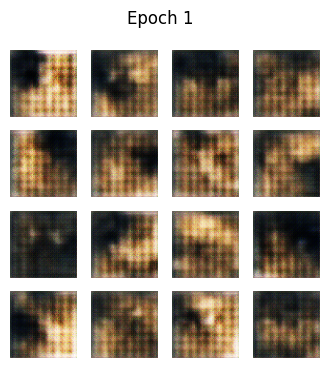

Epoch 2 /100 | Generator Loss: 0.7967610955238342 ,  Discrimintor Loss: 1.396411657333374
Epoch 3 /100 | Generator Loss: 0.7821097373962402 ,  Discrimintor Loss: 1.4040420055389404
Epoch 4 /100 | Generator Loss: 0.7873356342315674 ,  Discrimintor Loss: 1.3977713584899902
Epoch 5 /100 | Generator Loss: 0.7895640730857849 ,  Discrimintor Loss: 1.39202082157135
Epoch 6 /100 | Generator Loss: 0.7963247895240784 ,  Discrimintor Loss: 1.3823078870773315
Epoch 7 /100 | Generator Loss: 0.8110213875770569 ,  Discrimintor Loss: 1.3761097192764282
Epoch 8 /100 | Generator Loss: 0.8138596415519714 ,  Discrimintor Loss: 1.372072458267212
Epoch 9 /100 | Generator Loss: 0.805704653263092 ,  Discrimintor Loss: 1.3821474313735962
Epoch 10 /100 | Generator Loss: 0.7978554368019104 ,  Discrimintor Loss: 1.3875384330749512


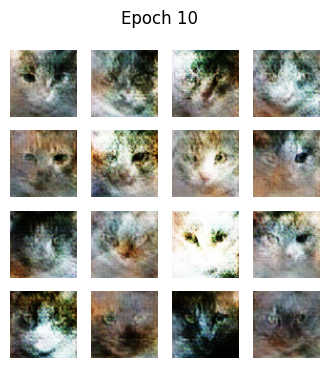

Epoch 11 /100 | Generator Loss: 0.7994901537895203 ,  Discrimintor Loss: 1.3855745792388916
Epoch 12 /100 | Generator Loss: 0.7972644567489624 ,  Discrimintor Loss: 1.3843624591827393
Epoch 13 /100 | Generator Loss: 0.7984355092048645 ,  Discrimintor Loss: 1.3832162618637085
Epoch 14 /100 | Generator Loss: 0.7983617186546326 ,  Discrimintor Loss: 1.3826149702072144
Epoch 15 /100 | Generator Loss: 0.799926221370697 ,  Discrimintor Loss: 1.381070613861084
Epoch 16 /100 | Generator Loss: 0.8027569055557251 ,  Discrimintor Loss: 1.379693865776062
Epoch 17 /100 | Generator Loss: 0.8022714257240295 ,  Discrimintor Loss: 1.3799333572387695
Epoch 18 /100 | Generator Loss: 0.8033003807067871 ,  Discrimintor Loss: 1.3790149688720703
Epoch 19 /100 | Generator Loss: 0.8070469498634338 ,  Discrimintor Loss: 1.3758735656738281
Epoch 20 /100 | Generator Loss: 0.8091591596603394 ,  Discrimintor Loss: 1.376135230064392


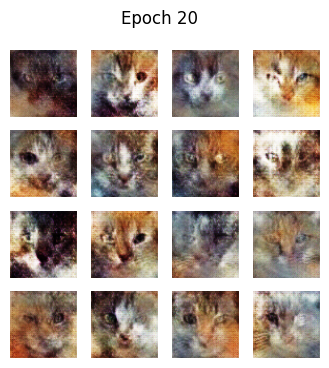

Epoch 21 /100 | Generator Loss: 0.8123406767845154 ,  Discrimintor Loss: 1.3729565143585205
Epoch 22 /100 | Generator Loss: 0.8103726506233215 ,  Discrimintor Loss: 1.3732362985610962
Epoch 23 /100 | Generator Loss: 0.812135636806488 ,  Discrimintor Loss: 1.3706245422363281
Epoch 24 /100 | Generator Loss: 0.8156232237815857 ,  Discrimintor Loss: 1.3704900741577148
Epoch 25 /100 | Generator Loss: 0.8185679912567139 ,  Discrimintor Loss: 1.367285132408142
Epoch 26 /100 | Generator Loss: 0.8217782974243164 ,  Discrimintor Loss: 1.3648521900177002
Epoch 27 /100 | Generator Loss: 0.8284890055656433 ,  Discrimintor Loss: 1.360115647315979
Epoch 28 /100 | Generator Loss: 0.8304216861724854 ,  Discrimintor Loss: 1.3552671670913696
Epoch 29 /100 | Generator Loss: 0.8342026472091675 ,  Discrimintor Loss: 1.3540785312652588
Epoch 30 /100 | Generator Loss: 0.852249026298523 ,  Discrimintor Loss: 1.344116449356079


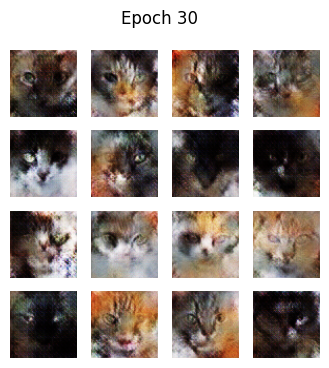

Epoch 31 /100 | Generator Loss: 0.840585470199585 ,  Discrimintor Loss: 1.3461852073669434
Epoch 32 /100 | Generator Loss: 0.857272744178772 ,  Discrimintor Loss: 1.3389259576797485
Epoch 33 /100 | Generator Loss: 0.8571714758872986 ,  Discrimintor Loss: 1.337104082107544
Epoch 34 /100 | Generator Loss: 0.8549838662147522 ,  Discrimintor Loss: 1.3405101299285889
Epoch 35 /100 | Generator Loss: 0.8519867658615112 ,  Discrimintor Loss: 1.3394813537597656
Epoch 36 /100 | Generator Loss: 0.8573691844940186 ,  Discrimintor Loss: 1.338618516921997
Epoch 37 /100 | Generator Loss: 0.8507994413375854 ,  Discrimintor Loss: 1.3428488969802856
Epoch 38 /100 | Generator Loss: 0.8493529558181763 ,  Discrimintor Loss: 1.3454217910766602
Epoch 39 /100 | Generator Loss: 0.8477327227592468 ,  Discrimintor Loss: 1.346407413482666
Epoch 40 /100 | Generator Loss: 0.8553082346916199 ,  Discrimintor Loss: 1.3412445783615112


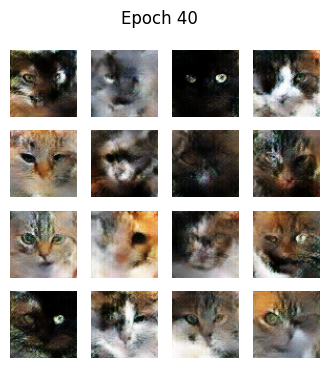

Epoch 41 /100 | Generator Loss: 0.8562309145927429 ,  Discrimintor Loss: 1.3380675315856934
Epoch 42 /100 | Generator Loss: 0.8491178750991821 ,  Discrimintor Loss: 1.3474888801574707
Epoch 43 /100 | Generator Loss: 0.8546567559242249 ,  Discrimintor Loss: 1.3407411575317383
Epoch 44 /100 | Generator Loss: 0.8506816625595093 ,  Discrimintor Loss: 1.3443175554275513
Epoch 45 /100 | Generator Loss: 0.8499152660369873 ,  Discrimintor Loss: 1.344849705696106
Epoch 46 /100 | Generator Loss: 0.8562626838684082 ,  Discrimintor Loss: 1.3415743112564087
Epoch 47 /100 | Generator Loss: 0.8578382134437561 ,  Discrimintor Loss: 1.3408297300338745
Epoch 48 /100 | Generator Loss: 0.8554381728172302 ,  Discrimintor Loss: 1.342441201210022
Epoch 49 /100 | Generator Loss: 0.8476383686065674 ,  Discrimintor Loss: 1.346998691558838
Epoch 50 /100 | Generator Loss: 0.8672501444816589 ,  Discrimintor Loss: 1.3401668071746826


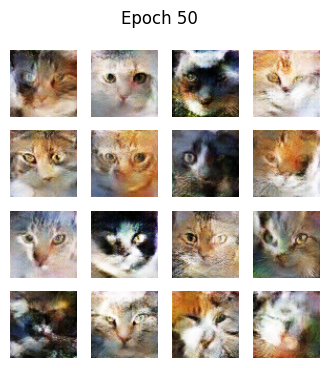

Epoch 51 /100 | Generator Loss: 0.8502714037895203 ,  Discrimintor Loss: 1.3451745510101318
Epoch 52 /100 | Generator Loss: 0.8522008657455444 ,  Discrimintor Loss: 1.3426488637924194
Epoch 53 /100 | Generator Loss: 0.8545868992805481 ,  Discrimintor Loss: 1.3428077697753906
Epoch 54 /100 | Generator Loss: 0.8611656427383423 ,  Discrimintor Loss: 1.3432133197784424
Epoch 55 /100 | Generator Loss: 0.8501402139663696 ,  Discrimintor Loss: 1.3470406532287598
Epoch 56 /100 | Generator Loss: 0.8446497321128845 ,  Discrimintor Loss: 1.352590560913086
Epoch 57 /100 | Generator Loss: 0.8474252223968506 ,  Discrimintor Loss: 1.351088047027588
Epoch 58 /100 | Generator Loss: 0.847346842288971 ,  Discrimintor Loss: 1.3521095514297485
Epoch 59 /100 | Generator Loss: 0.8435187935829163 ,  Discrimintor Loss: 1.3566890954971313
Epoch 60 /100 | Generator Loss: 0.8381949663162231 ,  Discrimintor Loss: 1.3616900444030762


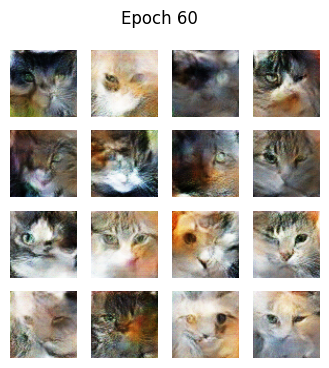

Epoch 61 /100 | Generator Loss: 0.8380810618400574 ,  Discrimintor Loss: 1.3602644205093384
Epoch 62 /100 | Generator Loss: 0.834645688533783 ,  Discrimintor Loss: 1.3634119033813477
Epoch 63 /100 | Generator Loss: 0.8374786972999573 ,  Discrimintor Loss: 1.3615542650222778
Epoch 64 /100 | Generator Loss: 0.8334439992904663 ,  Discrimintor Loss: 1.3628038167953491
Epoch 65 /100 | Generator Loss: 0.8306884765625 ,  Discrimintor Loss: 1.36573326587677
Epoch 66 /100 | Generator Loss: 0.8305737376213074 ,  Discrimintor Loss: 1.3658596277236938
Epoch 67 /100 | Generator Loss: 0.8327286243438721 ,  Discrimintor Loss: 1.3639250993728638
Epoch 68 /100 | Generator Loss: 0.8311729431152344 ,  Discrimintor Loss: 1.3654329776763916
Epoch 69 /100 | Generator Loss: 0.8283582329750061 ,  Discrimintor Loss: 1.3683634996414185
Epoch 70 /100 | Generator Loss: 0.8293847441673279 ,  Discrimintor Loss: 1.366147756576538


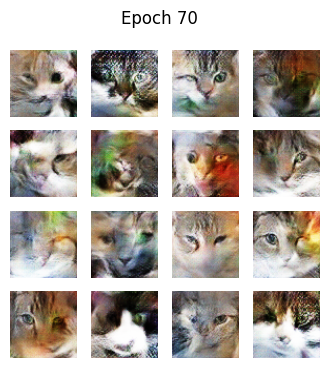

Epoch 71 /100 | Generator Loss: 0.8285843729972839 ,  Discrimintor Loss: 1.3673973083496094
Epoch 72 /100 | Generator Loss: 0.8271852731704712 ,  Discrimintor Loss: 1.3689924478530884
Epoch 73 /100 | Generator Loss: 0.8291279077529907 ,  Discrimintor Loss: 1.3663551807403564
Epoch 74 /100 | Generator Loss: 0.8253209590911865 ,  Discrimintor Loss: 1.368884801864624
Epoch 75 /100 | Generator Loss: 0.8247327208518982 ,  Discrimintor Loss: 1.3694547414779663
Epoch 76 /100 | Generator Loss: 0.8244653940200806 ,  Discrimintor Loss: 1.3701993227005005
Epoch 77 /100 | Generator Loss: 0.8249228596687317 ,  Discrimintor Loss: 1.3703625202178955
Epoch 78 /100 | Generator Loss: 0.8220910429954529 ,  Discrimintor Loss: 1.3726321458816528
Epoch 79 /100 | Generator Loss: 0.822871744632721 ,  Discrimintor Loss: 1.3706294298171997
Epoch 80 /100 | Generator Loss: 0.8212166428565979 ,  Discrimintor Loss: 1.3721050024032593


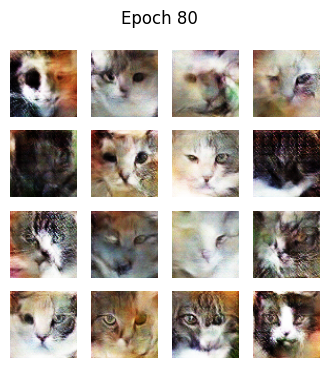

Epoch 81 /100 | Generator Loss: 0.8231934905052185 ,  Discrimintor Loss: 1.3707094192504883
Epoch 82 /100 | Generator Loss: 0.8208631277084351 ,  Discrimintor Loss: 1.372071385383606
Epoch 83 /100 | Generator Loss: 0.822265088558197 ,  Discrimintor Loss: 1.3708478212356567
Epoch 84 /100 | Generator Loss: 0.8218666315078735 ,  Discrimintor Loss: 1.372101068496704
Epoch 85 /100 | Generator Loss: 0.8198406100273132 ,  Discrimintor Loss: 1.3719626665115356
Epoch 86 /100 | Generator Loss: 0.8199611306190491 ,  Discrimintor Loss: 1.3728601932525635
Epoch 87 /100 | Generator Loss: 0.8213512301445007 ,  Discrimintor Loss: 1.369946002960205
Epoch 88 /100 | Generator Loss: 0.821487545967102 ,  Discrimintor Loss: 1.3714792728424072
Epoch 89 /100 | Generator Loss: 0.8196122050285339 ,  Discrimintor Loss: 1.3714919090270996
Epoch 90 /100 | Generator Loss: 0.8197652697563171 ,  Discrimintor Loss: 1.3721996545791626


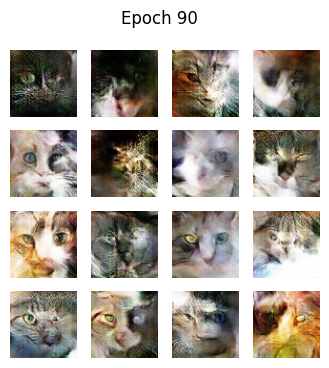

Epoch 91 /100 | Generator Loss: 0.8196476697921753 ,  Discrimintor Loss: 1.3714029788970947
Epoch 92 /100 | Generator Loss: 0.8198630809783936 ,  Discrimintor Loss: 1.3724017143249512
Epoch 93 /100 | Generator Loss: 0.8202027082443237 ,  Discrimintor Loss: 1.3710969686508179
Epoch 94 /100 | Generator Loss: 0.8203536868095398 ,  Discrimintor Loss: 1.3712210655212402
Epoch 95 /100 | Generator Loss: 0.8189257383346558 ,  Discrimintor Loss: 1.3719490766525269
Epoch 96 /100 | Generator Loss: 0.8196635842323303 ,  Discrimintor Loss: 1.372878909111023
Epoch 97 /100 | Generator Loss: 0.8190168142318726 ,  Discrimintor Loss: 1.371482253074646
Epoch 98 /100 | Generator Loss: 0.8192344903945923 ,  Discrimintor Loss: 1.3721117973327637
Epoch 99 /100 | Generator Loss: 0.8162765502929688 ,  Discrimintor Loss: 1.3731896877288818
Epoch 100 /100 | Generator Loss: 0.8188027143478394 ,  Discrimintor Loss: 1.3725874423980713


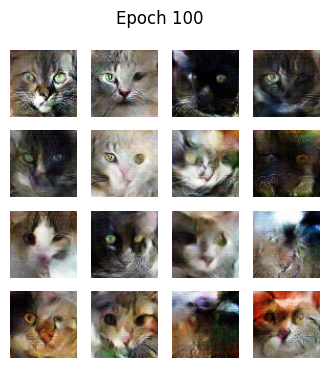

In [14]:
train(dataset)


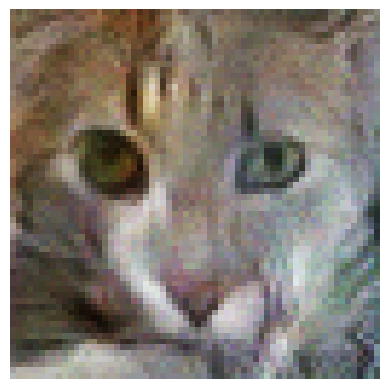

In [29]:
#generate new cat image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image =(generated_image + 1) /2

plt.imshow(generated_image[0])
plt.axis('off')
plt.show()

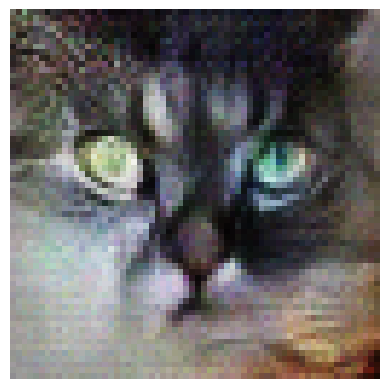

In [32]:
#generate new cat image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image =(generated_image + 1) /2

plt.imshow(generated_image[0])
plt.axis('off')
plt.show()

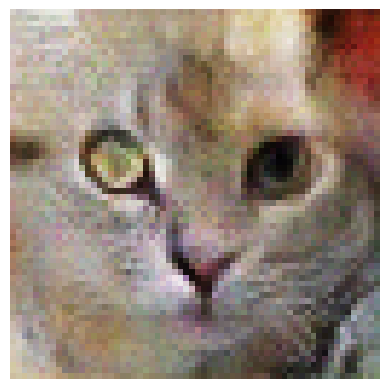

In [67]:
#generate new cat image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image =(generated_image + 1) /2

plt.imshow(generated_image[0])
plt.axis('off')
plt.show()

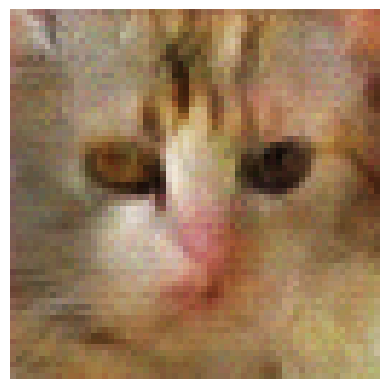

In [114]:
#generate new cat image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image =(generated_image + 1) /2

plt.imshow(generated_image[0])
plt.axis('off')
plt.show()